
# Loan Default Prediction (Credit Risk Modeling)

This notebook builds a simple, interview-ready **Loan Default Prediction** model using **Logistic Regression**.
The workflow mirrors an industry pipeline:
1. Load & explore data
2. Preprocess (handle missing values, encode categoricals)
3. Train Logistic Regression
4. Evaluate with **Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix, KS, Gini**
5. Inspect feature importance (coefficients)
6. (Optional) Compare with Random Forest

> **Dataset note:**  
> - If a file named `loan_data.csv` exists in the working directory, the notebook will use it.  
> - Otherwise, it will **generate a synthetic dataset** so you can run everything end-to-end immediately.  
> - To use a real dataset later, just place it as `loan_data.csv` with a binary target column named `default` (0/1).


In [1]:
import pandas as pd

# check the input folder
!ls /kaggle/input

# then load dataset
df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz", low_memory=False)

# Sample smaller data for practice
df = df.sample(50000, random_state=42)

# Look at first rows
df.head()


lending-club


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
392949,39651438,NaN,32000.0,32000.0,32000.0,60 months,10.49,687.65,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1273506,16411620,NaN,9600.0,9600.0,9600.0,36 months,12.99,323.42,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
324024,45122316,NaN,4000.0,4000.0,4000.0,36 months,6.68,122.93,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2066630,125356772,NaN,6025.0,6025.0,6025.0,36 months,10.91,197.00,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
477199,128490686,NaN,25000.0,25000.0,25000.0,60 months,26.30,752.96,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [12]:


# Select useful columns
important_cols = [
    "loan_amnt", "term", "int_rate", "grade", "annual_inc", "installment"
]
df = df[important_cols]
df



,loan_amnt,term,int_rate,grade,annual_inc,installment
392949,32000.0,60,10.49,2,120000.0,687.65
1273506,9600.0,36,12.99,3,21900.0,323.42
324024,4000.0,36,6.68,1,83000.0,122.93
2066630,6025.0,36,10.91,2,52000.0,197.00
477199,25000.0,60,26.30,5,65000.0,752.96
...,...,...,...,...,...,...
2184780,15000.0,36,12.74,3,80080.0,503.54
1297457,27500.0,36,12.49,2,180000.0,919.85
1881631,10000.0,36,15.31,3,72000.0,348.18
2159737,6025.0,36,11.49,2,22000.0,198.66


In [5]:
# Check data type first
print(df["int_rate"].dtype)
print(df["int_rate"].head())


float64
392949     10.49
1273506    12.99
324024      6.68
2066630    10.91
477199     26.30
Name: int_rate, dtype: float64


In [6]:
# Drop missing rows
df = df.dropna(subset=["loan_amnt", "term", "int_rate", "grade", "annual_inc", "installment"])

# Convert term (36 months, 60 months) → numeric
df["term"] = df["term"].astype(str).str.replace(" months", "").astype(int)

# Ensure interest rate is numeric
df["int_rate"] = pd.to_numeric(df["int_rate"], errors="coerce")

# Map grade (A,B,C..) → numeric
grade_mapping = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7}
df["grade"] = df["grade"].map(grade_mapping)


In [7]:
X = df[["term", "int_rate", "grade", "annual_inc", "installment"]]  # features
y = df["loan_amnt"]  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [9]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 1329.4319704035624
R² Score: 0.9789399113331804


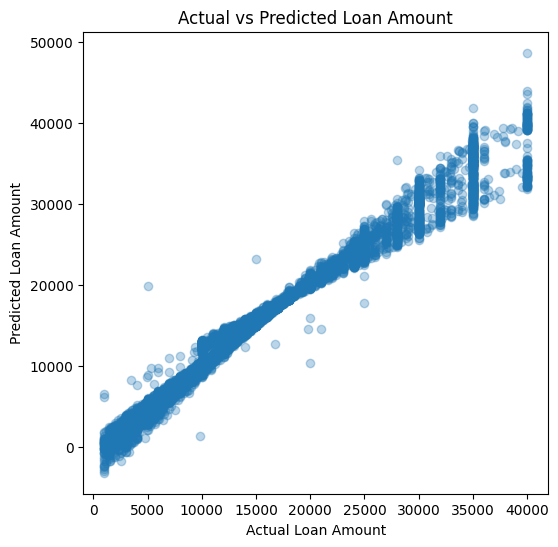

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted Loan Amount")
plt.show()
